In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/legal-citation-text-classification/legal_text_classification.csv
/kaggle/input/common-law-vocab/common_law.csv


# EDA
1. display data
2. data cleaning - drop na, drop dup
3. avg case_tile, case_text length
4. distribution of case_outcome
5. keywords
6. tf_idf
7. clustering
8. word2vec


In [2]:
# EDA

# display column
df = pd.read_csv("/kaggle/input/legal-citation-text-classification/legal_text_classification.csv")
df.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [3]:
df.isnull().sum()

case_id           0
case_outcome      0
case_title        0
case_text       176
dtype: int64

In [4]:
df = df.drop_duplicates().dropna()

Text(0.5, 0, 'Number of ocurrences')

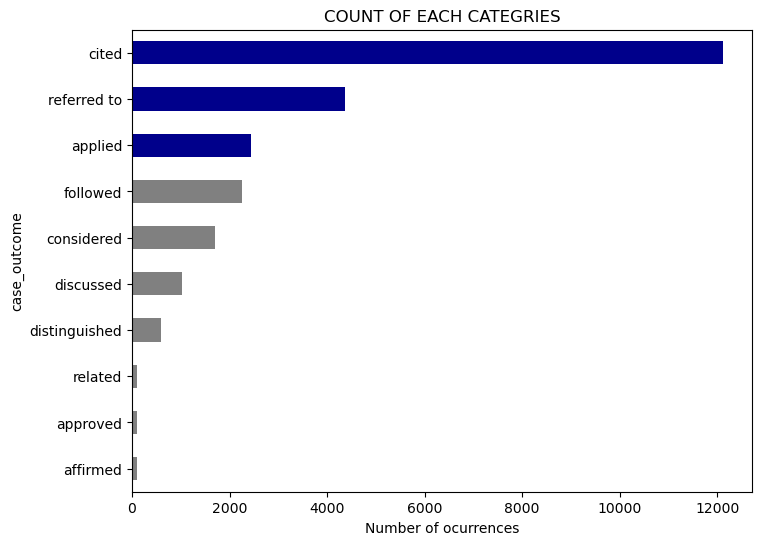

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','darkblue','darkblue','darkblue']
df.groupby('case_outcome')['case_id'].count().sort_values().plot.barh(ylim=0, color=colors, title= 'COUNT OF EACH CATEGRIES')
plt.xlabel('Number of ocurrences', fontsize = 10)

In [6]:
df['case_title_length'] = df['case_title'].str.len()
df['case_text_length'] = df['case_text'].str.len()
df['case_title_log_length'] = np.log(1+df['case_title_length'])
df['case_text_log_length'] = np.log(1+df['case_text_length'])

<Axes: >

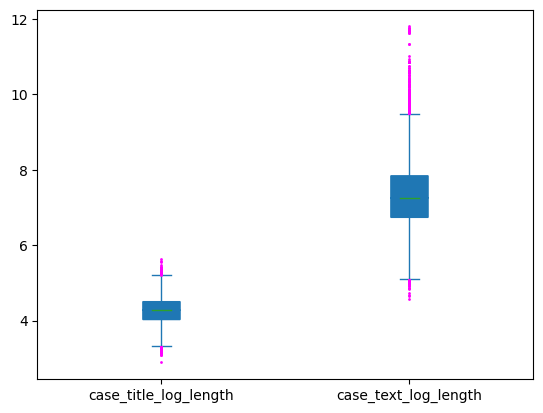

In [7]:
# box plot of length
flierprops = {'markerfacecolor': 'fuchsia', 'marker': 'o', 'markersize': 2, 'markeredgewidth': 0.0}
df[['case_title_log_length', 'case_text_log_length']].plot.box(flierprops=flierprops, notch=True, patch_artist=True, labels=['case title log length', 'case text log length'])

Text(0.5, 0, 'Case Title Log Length')

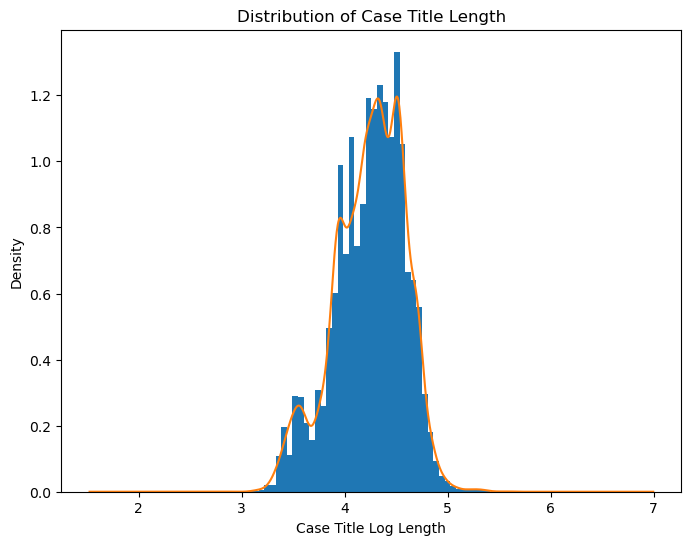

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df['case_title_log_length'].plot.hist(bins=50,ylim=0, density=True, title= 'Distribution of Case Title Length')
df['case_title_log_length'].plot.kde(ylim=0)
plt.xlabel('Case Title Log Length', fontsize = 10)

Text(0.5, 0, 'Case Text Log Length')

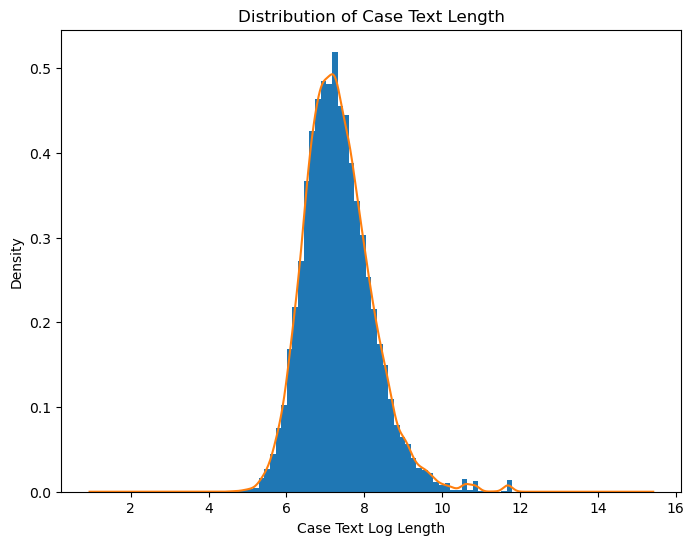

In [9]:
fig = plt.figure(figsize=(8,6))
df['case_text_log_length'].plot.hist(bins=50,ylim=0, density=True, title= 'Distribution of Case Text Length')
df['case_text_log_length'].plot.kde(ylim=0)
plt.xlabel('Case Text Log Length', fontsize = 10)

<Axes: xlabel='case_outcome', ylabel='case_text_log_length'>

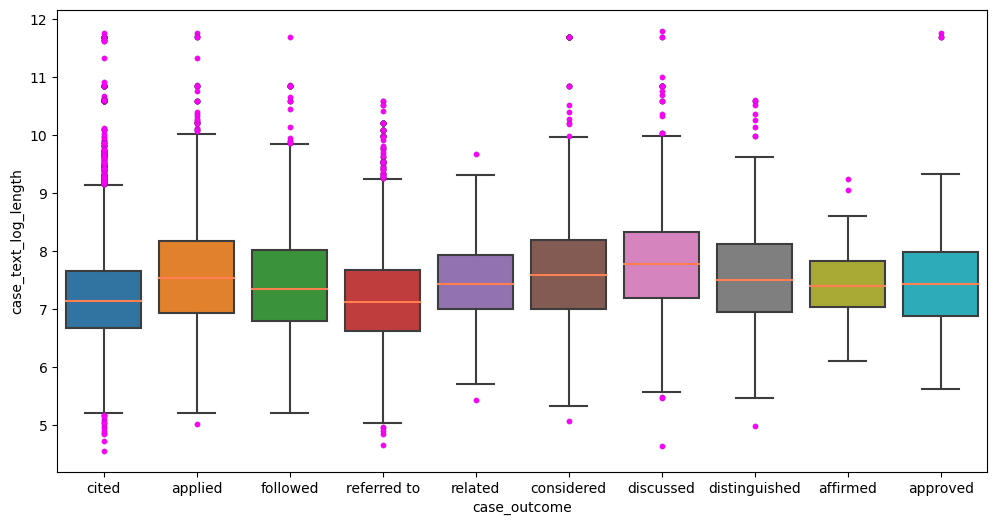

In [10]:
# distribution of 
flierprops = {'markerfacecolor': 'fuchsia', 'marker': 'o', 'markersize': 4, 'markeredgewidth': 0.1}

import seaborn as sns
fig = plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='case_outcome', y='case_text_log_length', flierprops=flierprops, medianprops={"color": "coral"})

<Axes: xlabel='case_outcome', ylabel='case_text_length'>

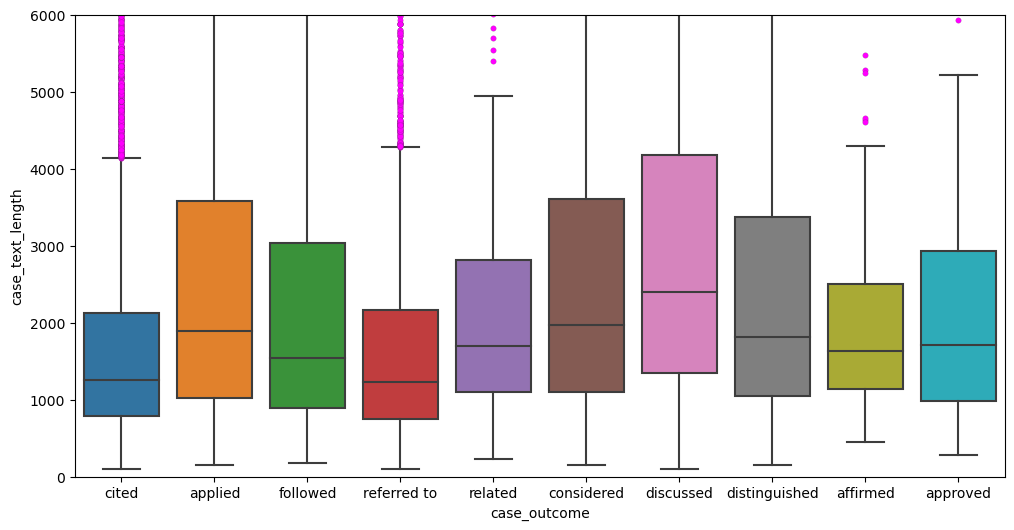

In [11]:
# distribution of 
flierprops = {'markerfacecolor': 'fuchsia', 'marker': 'o', 'markersize': 4, 'markeredgewidth': 0.1}
fig = plt.figure(figsize=(12,6))
plt.ylim(0, 6000)
sns.boxplot(data=df, x='case_outcome', y='case_text_length', flierprops=flierprops)

<Axes: xlabel='case_outcome', ylabel='case_title_log_length'>

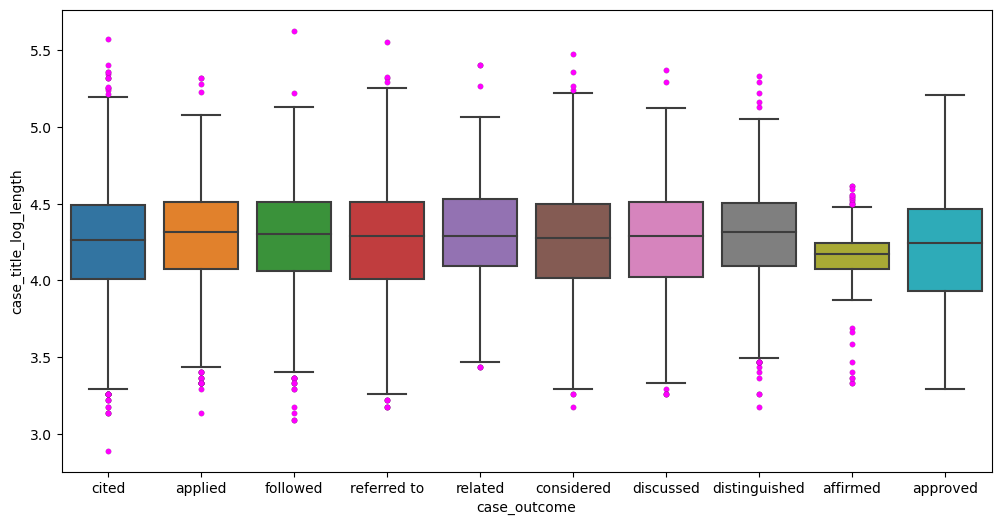

In [12]:
flierprops = {'markerfacecolor': 'fuchsia', 'marker': 'o', 'markersize': 4, 'markeredgewidth': 0.1}

import seaborn as sns
fig = plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='case_outcome', y='case_title_log_length', flierprops=flierprops)

# Tokenization

In [13]:
import nltk
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
stop = stopwords.words('english')

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree


In [14]:
#storing the puntuation free text
df['case_text']=df['case_text'].astype('str')

df['case_text']= df['case_text'].apply(lambda x:remove_punctuation(x))


#Making the case consistent as lower
df['case_text']= df['case_text'].apply(lambda x: x.lower())
df['case_text']= df['case_text'].str.replace('\d+', '')


#Removing Stop Words
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.

df['case_text']=df['case_text']
df['case_text'] = df['case_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

/tmp/ipykernel_20/619352760.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['case_text']= df['case_text'].str.replace('\d+', '')


In [15]:
#storing the puntuation free text
df['case_title']=df['case_title'].astype('str')

df['case_title']= df['case_title'].apply(lambda x:remove_punctuation(x))


#Making the case consistent as lower
df['case_title']= df['case_title'].apply(lambda x: x.lower())
df['case_title']= df['case_title'].str.replace('\d+', '')


#Removing Stop Words
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.

df['case_title']=df['case_title']
df['case_title'] = df['case_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

/tmp/ipykernel_20/1524916072.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['case_title']= df['case_title'].str.replace('\d+', '')


In [16]:
df['case_text_words_count'] = df['case_text'].apply(lambda x: len(x.split()))
df['case_title_words_count'] = df['case_title'].apply(lambda x: len(x.split()))

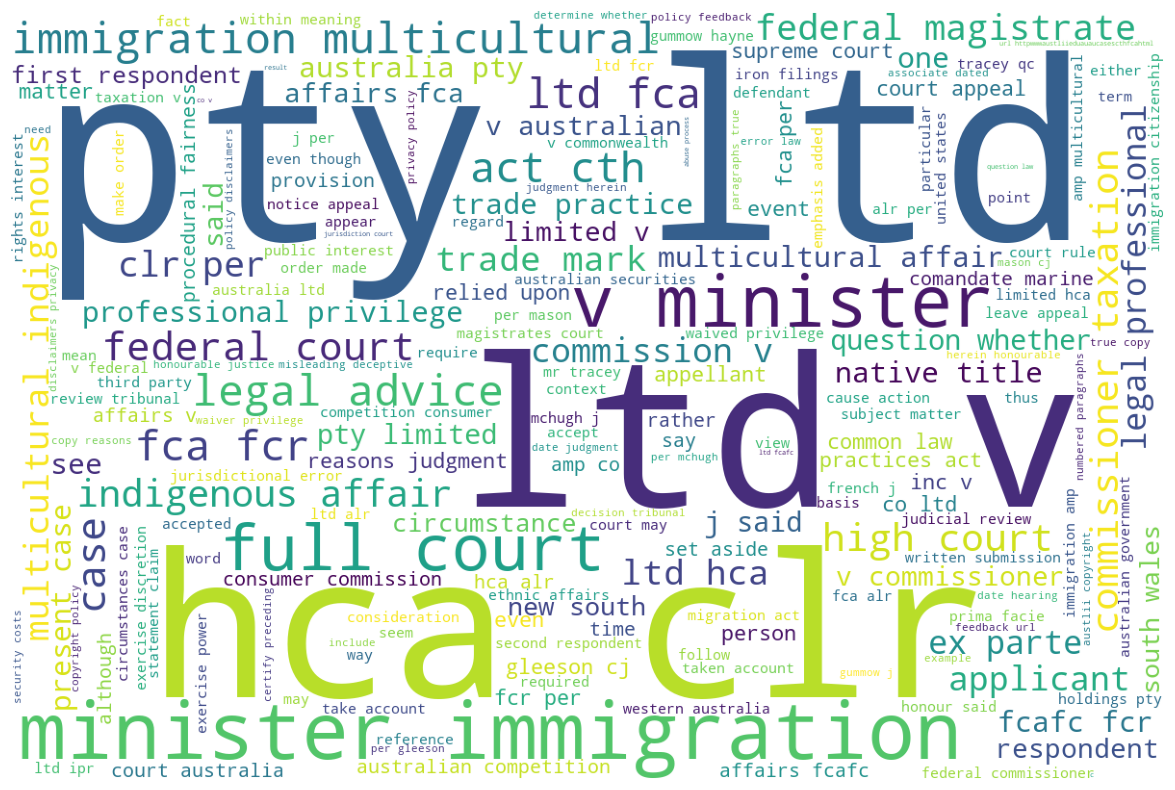

In [17]:
#Adding features character length, word length and Polarity score for each record
from wordcloud import WordCloud

fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
Cloud_text = ' '.join(df['case_text'])
wordcloud2 = WordCloud( background_color = 'white',width=1200, height=800).generate(Cloud_text)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()


<Axes: xlabel='case_outcome', ylabel='case_title_words_count_log'>

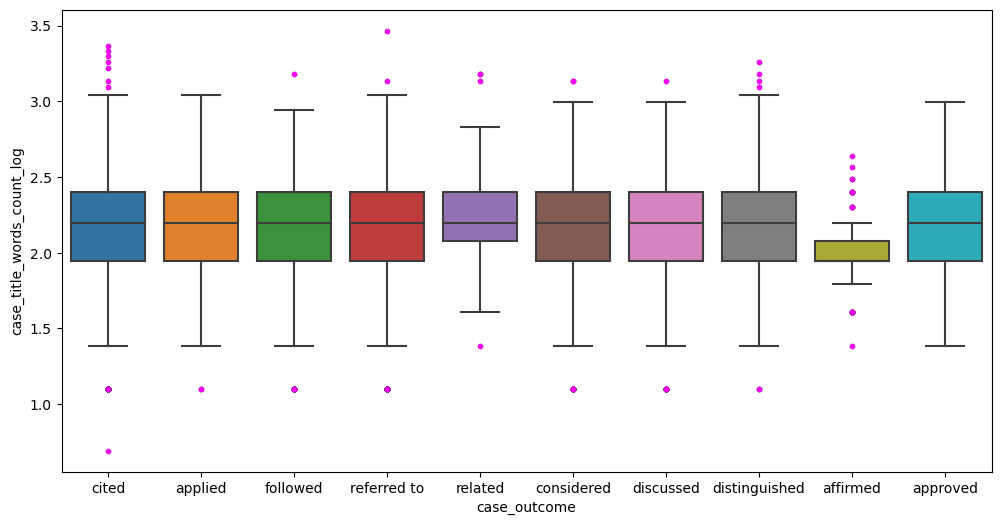

In [18]:
# distribution of 
df['case_title_words_count_log'] = np.log(1+df['case_title_words_count'])
flierprops = {'markerfacecolor': 'fuchsia', 'marker': 'o', 'markersize': 4, 'markeredgewidth': 0.1}
fig = plt.figure(figsize=(12,6))
# plt.ylim(0, 6000)
sns.boxplot(data=df, x='case_outcome', y='case_title_words_count_log', flierprops=flierprops)

<Axes: xlabel='case_outcome', ylabel='case_text_words_count_log'>

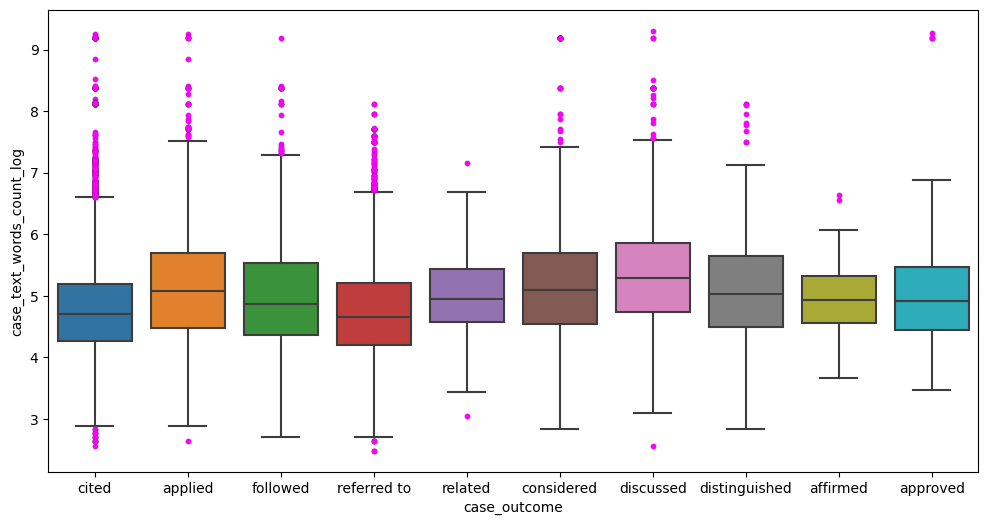

In [19]:
# distribution of 
df['case_text_words_count_log'] = np.log(1+df['case_text_words_count'])
flierprops = {'markerfacecolor': 'fuchsia', 'marker': 'o', 'markersize': 4, 'markeredgewidth': 0.1}
fig = plt.figure(figsize=(12,6))
# plt.ylim(0, 6000)
sns.boxplot(data=df, x='case_outcome', y='case_text_words_count_log', flierprops=flierprops)

# TOP Words

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus):
    vec = CountVectorizer(stop_words = 'english', min_df=10, max_df=0.2).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq


In [21]:

common_words = get_top_n_words(df['case_text'])
df_unigram = pd.DataFrame(common_words[:20], columns = ['Word' , 'count']).sort_values(by="count",ascending=False).reset_index(drop=True)

<Axes: ylabel='Word'>

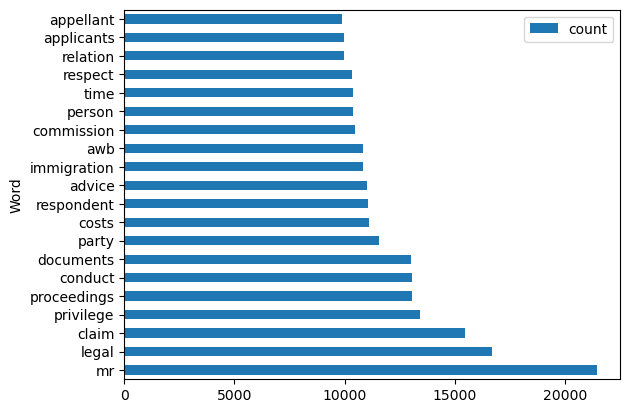

In [22]:
df_unigram.plot.barh(x='Word', y='count')

<Axes: ylabel='Frequency'>

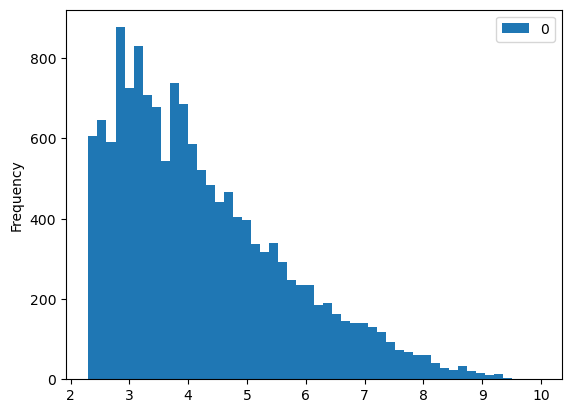

In [23]:
import math
pd.DataFrame(map(lambda x: math.log(x[1]), common_words)).plot.hist(bins=50)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=20000,
#                         ngram_range=(1, 2), 
                        stop_words='english')

vectors = tfidf.fit_transform(df['case_text'])


In [25]:
feature_names = tfidf.get_feature_names_out()
tf_idf_array = vectors.toarray()

In [26]:
# tf_idf_df = pd.DataFrame(data=tf_idf_array, columns=list(feature_names))
count_lst = tf_idf_array.sum(axis=0)
mean_lst = tf_idf_array.mean(axis=0)

vocab_df = pd.DataFrame((zip(feature_names,count_lst, mean_lst)),
                          columns= ["vocab","tfidf_sum_value", "tfidf_mean_value"]).sort_values(by="tfidf_mean_value",ascending=False).reset_index(drop=True)


In [27]:
vocab_df.head()

,vocab,tfidf_sum_value,tfidf_mean_value
0,court,726.020591,0.029264
1,pty,637.277534,0.025687
2,fca,581.913809,0.023456
3,act,543.954083,0.021926
4,hca,536.443656,0.021623


# with law vocab

In [28]:
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/legal-citation-text-classification/legal_text_classification.csv
/kaggle/input/common-law-vocab/common_law.csv


In [29]:
common_law_df = pd.read_csv('/kaggle/input/common-law-vocab/common_law.csv')
common_law_df.head()

,Term Locale,Term Category,Term,Case Sensitive
0,en-US,Legal,A AVER ET TENER,False
1,en-US,Legal,A CCELO USQUE AD CENTRUM,False
2,en-US,Legal,A CONSILHS,False
3,en-US,Legal,A CUEILLETTE,False
4,en-US,Legal,A DATU,False


In [30]:
common_law_vocab = common_law_df['Term'].str.lower().drop_duplicates().dropna()

In [31]:
corpus = df['case_text'].str.lower()

In [32]:
# convert description to lower case
def get_top_n_words(corpus, vocab, ngram_range=(1,1), min_df=0.01, max_df=0.3):
    vec = CountVectorizer(stop_words = 'english', min_df=20, max_df=max_df,vocabulary=vocab, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq


In [33]:
common_law_term_words = get_top_n_words(corpus, common_law_vocab, ngram_range=(1,3))

<Axes: >

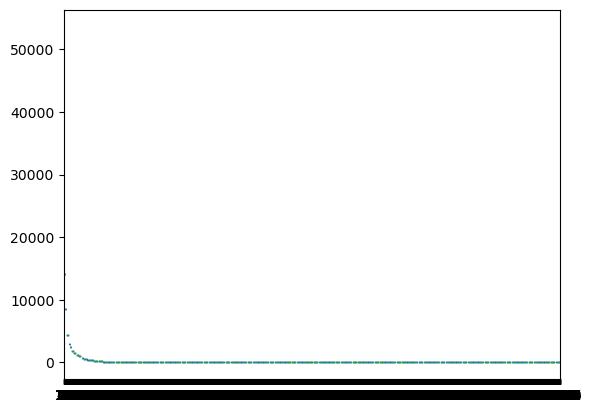

In [34]:
# pd.Series([x[1] for x in common_law_term_words]).box(bins=50)
pd.DataFrame(data=[[x[1] for x in common_law_term_words]]).plot.box(flierprops=flierprops, notch=True, patch_artist=True)
# df[['case_title_log_length', 'case_text_log_length']].plot.box(flierprops=flierprops, notch=True, patch_artist=True, labels=['case title log length', 'case text log length'])

In [35]:
# top 100 freq distribution


In [36]:
df_unigram_20 = pd.DataFrame(common_law_term_words[:20], columns = ['Word' , 'count']).sort_values(by="count",ascending=False).reset_index(drop=True)


In [37]:
# key word by different topic


## keywords by topic

In [38]:
df_cited = df[df['case_outcome']=='cited']
df_applied = df[df['case_outcome']=='applied']
df_followed= df[df['case_outcome']=='followed']
df_referred= df[df['case_outcome']=='referred to']
df_related= df[df['case_outcome']=='related']
df_considered= df[df['case_outcome']=='considered']
df_discussed= df[df['case_outcome']=='discussed']
df_distinguished= df[df['case_outcome']=='distinguished']
df_affirmed= df[df['case_outcome']=='affirmed']
df_approved= df[df['case_outcome']=='approved']

In [39]:
cited_common_law_term_words = get_top_n_words(df_cited['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))
applied_common_law_term_words = get_top_n_words(df_applied['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))

followed_common_law_term_words = get_top_n_words(df_followed['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))
referred_common_law_term_words = get_top_n_words(df_referred['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))

related_common_law_term_words = get_top_n_words(df_related['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))
considered_common_law_term_words = get_top_n_words(df_considered['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))


discussed_common_law_term_words = get_top_n_words(df_discussed['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))
distinguished_common_law_term_words = get_top_n_words(df_distinguished['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))

affirmed_common_law_term_words = get_top_n_words(df_affirmed['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))
approved_common_law_term_words = get_top_n_words(df_approved['case_text'].str.lower(), common_law_vocab, ngram_range=(1,3))


In [40]:
outcome_mapper = {
    'cited': cited_common_law_term_words,
    'applied': applied_common_law_term_words,
    'followed': followed_common_law_term_words,
    'referred': referred_common_law_term_words,
    'related': related_common_law_term_words,
    'considered': considered_common_law_term_words,
    'discussed': discussed_common_law_term_words,
    'distinguished': distinguished_common_law_term_words,
    'affirmed': affirmed_common_law_term_words,
    'approved': approved_common_law_term_words
}

In [41]:
def display(outcome, mi, ma, w=10, h=15):
    data = pd.DataFrame(outcome_mapper[outcome][mi:ma], columns = ['Word' , 'count']).sort_values(by="count",ascending=False).reset_index(drop=True)
    plt.figure(figsize=(w,h))
    title = '{} top {}~{} keywords'.format(outcome, mi, ma)
    data.plot.barh(x='Word', y='count', title=title)

<Figure size 1000x1500 with 0 Axes>

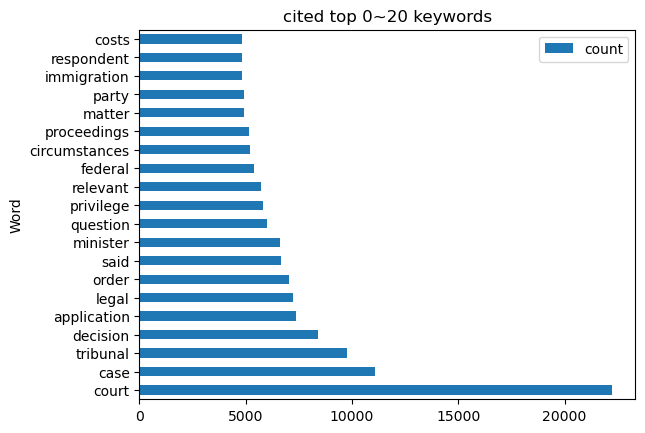

In [42]:
display('cited', 0, 20)

<Figure size 1000x2000 with 0 Axes>

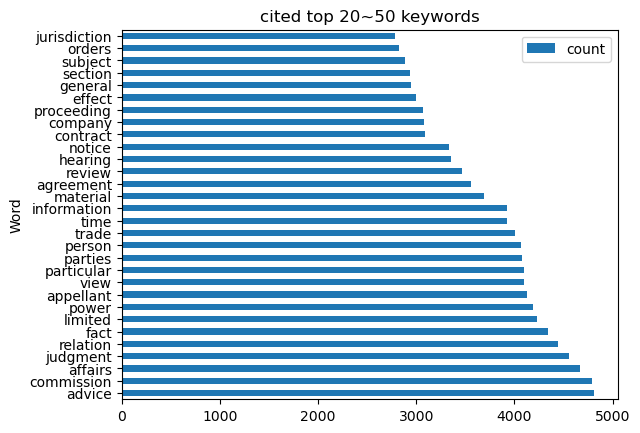

In [43]:
display('cited', 20, 50, h=20)

<Figure size 1000x1500 with 0 Axes>

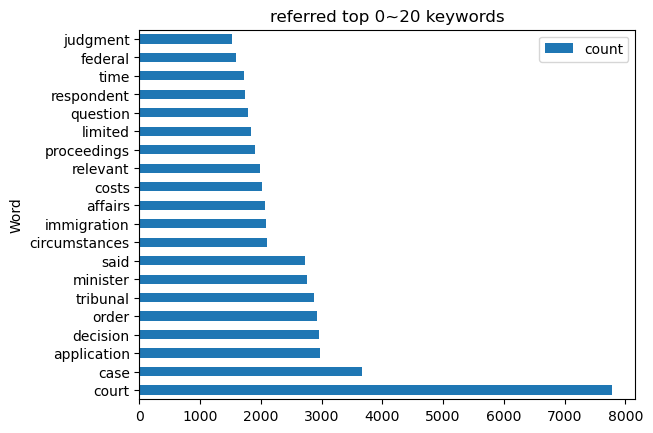

In [44]:
display('referred', 0, 20)

<Figure size 1000x1500 with 0 Axes>

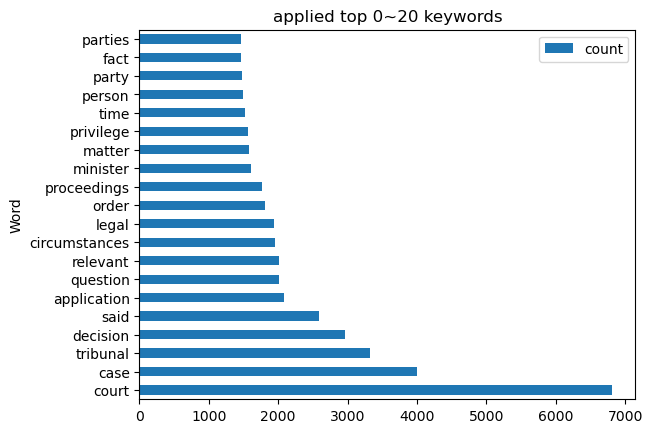

In [45]:

display('applied', 0, 20)

<Figure size 1000x1500 with 0 Axes>

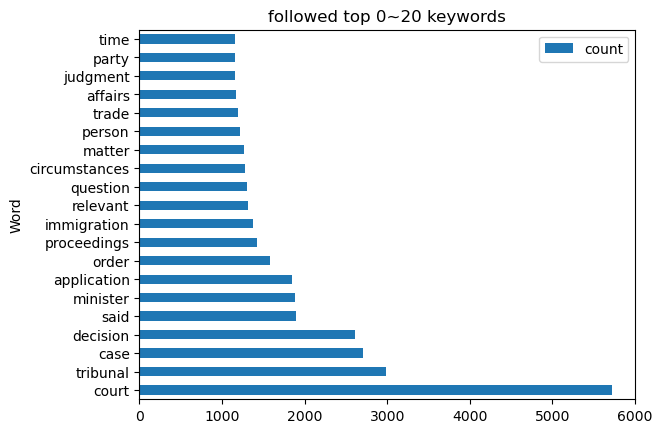

In [46]:
display('followed', 0, 20)

<Figure size 1000x1500 with 0 Axes>

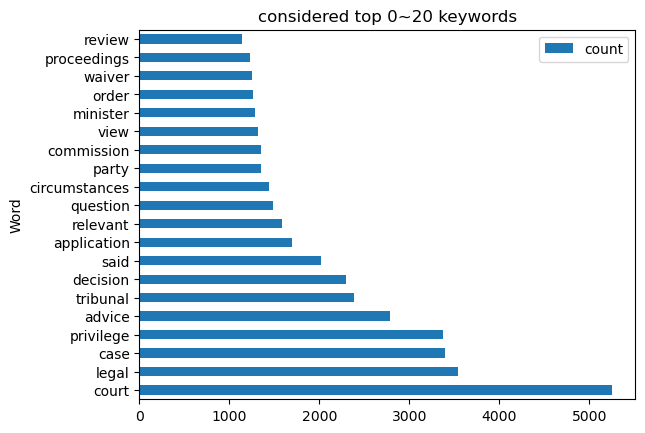

In [47]:
display('considered', 0, 20)

<Figure size 1000x1500 with 0 Axes>

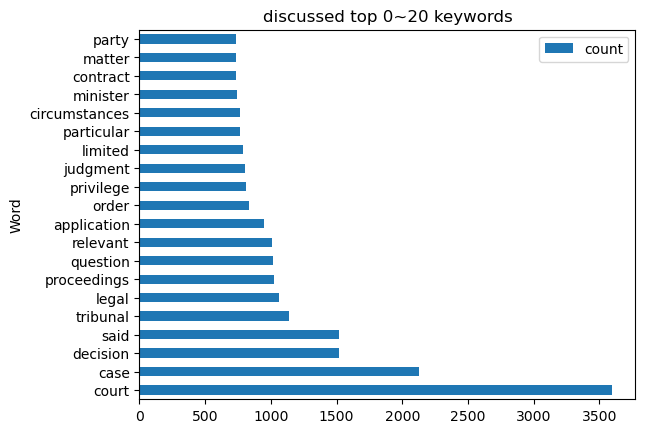

In [48]:
display('discussed', 0, 20)

In [49]:
def get_topn_df(mi, ma):
    data = pd.DataFrame()
    data['cited'] = list(map(lambda x:x[0], sorted(cited_common_law_term_words, key=lambda x: x[1], reverse=True)[mi:ma]))
    data['followed'] = list(map(lambda x:x[0], sorted(followed_common_law_term_words, key=lambda x: x[1], reverse=True)[mi:ma]))
    data['refered'] = list(map(lambda x:x[0], sorted(referred_common_law_term_words, key=lambda x: x[1], reverse=True)[mi:ma]))
    data['related'] = list(map(lambda x:x[0], sorted(related_common_law_term_words, key=lambda x: x[1], reverse=True)[mi:ma]))
    data['considered'] = list(map(lambda x:x[0], sorted(considered_common_law_term_words, key=lambda x: x[1], reverse=True)[mi:ma]))
    data['discussed'] = list(map(lambda x:x[0], sorted(discussed_common_law_term_words, key=lambda x: x[1], reverse=True)[mi:ma]))
    data['distinguished'] = list(map(lambda x:x[0], sorted(distinguished_common_law_term_words, key=lambda x: x[1], reverse=True)[mi:ma]))
    data['affirmed'] = list(map(lambda x:x[0], sorted(affirmed_common_law_term_words, key=lambda x: x[1], reverse=True)[mi:ma]))
    data['approved'] = list(map(lambda x:x[0], sorted(approved_common_law_term_words, key=lambda x: x[1], reverse=True)[mi:ma]))
    return data

In [50]:
def build_corr_df(data, mi, ma):
    m = len(data.columns)
    matrix = [[0 for _ in range(m)] for _ in range(m)]
    for i in range(m):
        for j in range(m):
            same_keywords = len(set(data[data.columns[i]]).intersection(set(data[data.columns[j]])))
            matrix[i][j] = 1.0*same_keywords/(ma-mi)
    return pd.DataFrame(matrix, columns=data.columns, index=data.columns)

In [51]:
def build_topn_similarity(mi, ma):
    return build_corr_df(get_topn_df(mi, ma), mi, ma)

[Text(0.5, 1.0, 'Top50 similarity')]

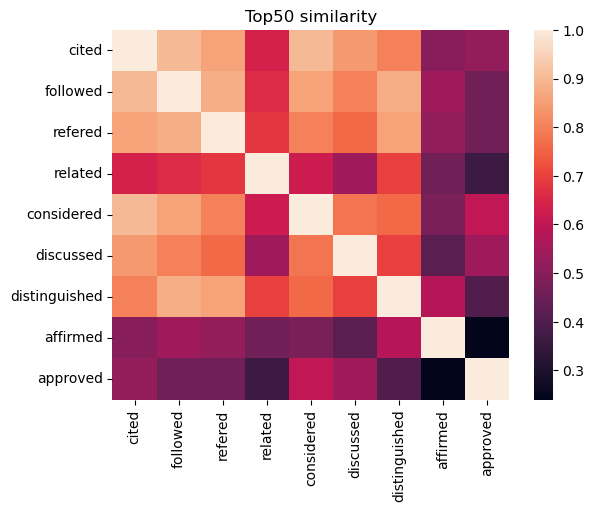

In [52]:
top50_similarity = build_topn_similarity(0, 50)
sns.heatmap(top50_similarity).set(title='Top50 similarity')

[Text(0.5, 1.0, 'Top 50 to 100 similarity')]

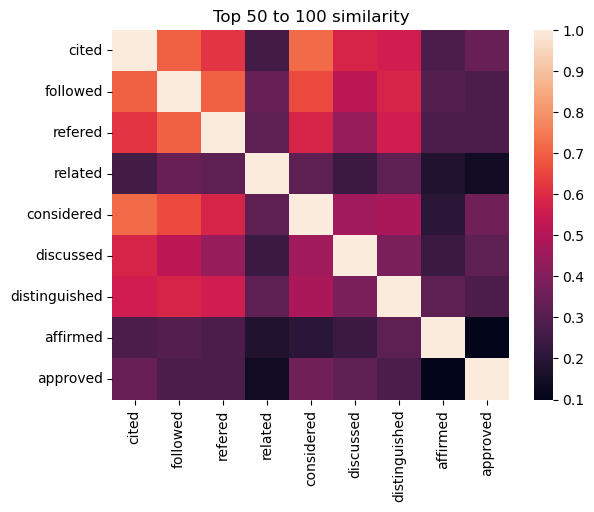

In [53]:
top50_100_similarity = build_topn_similarity(50, 100)
sns.heatmap(top50_100_similarity).set(title='Top 50 to 100 similarity')

[Text(0.5, 1.0, 'Top100 similarity')]

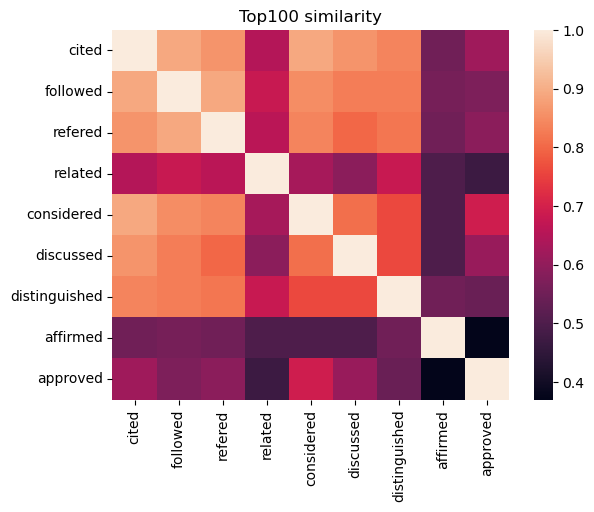

In [54]:
top100_similarity = build_topn_similarity(0, 100)
sns.heatmap(top100_similarity).set(title='Top100 similarity')

[Text(0.5, 1.0, 'Top200 similarity')]

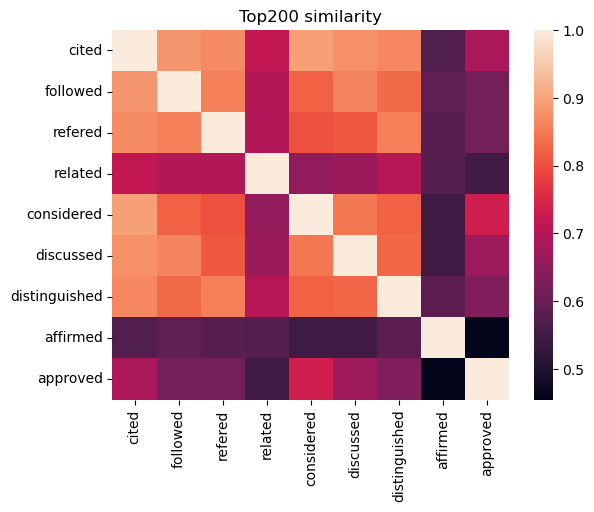

In [55]:
top200_similarity = build_topn_similarity(0, 200)
sns.heatmap(top200_similarity).set(title='Top200 similarity')

[Text(0.5, 1.0, 'Top 100 200 similarity')]

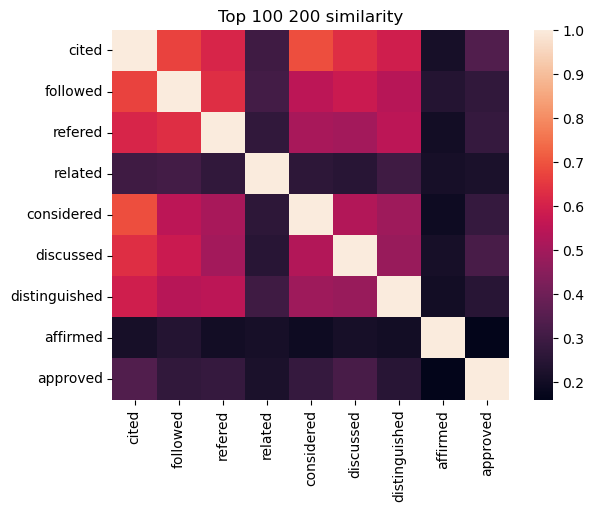

In [56]:
top100_200_similarity = build_topn_similarity(100, 200)
sns.heatmap(top100_200_similarity).set(title='Top 100 200 similarity')

In [57]:
top50_100_similarity

,cited,followed,refered,related,considered,discussed,distinguished,affirmed,approved
cited,1.00,0.70,0.62,0.26,0.72,0.58,0.56,0.28,0.34
followed,0.70,1.00,0.70,0.34,0.66,0.52,0.58,0.30,0.28
refered,0.62,0.70,1.00,0.32,0.58,0.44,0.56,0.28,0.28
related,0.26,0.34,0.32,1.00,0.32,0.24,0.32,0.18,0.14
considered,0.72,0.66,0.58,0.32,1.00,0.46,0.48,0.20,0.36
discussed,0.58,0.52,0.44,0.24,0.46,1.00,0.38,0.24,0.32
distinguished,0.56,0.58,0.56,0.32,0.48,0.38,1.00,0.32,0.28
affirmed,0.28,0.30,0.28,0.18,0.20,0.24,0.32,1.00,0.10
approved,0.34,0.28,0.28,0.14,0.36,0.32,0.28,0.10,1.00
